# Convolutional neural network

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This file is adapted from a notebook created by <a href="https://www.di.ens.fr/~lelarge/">Marc Lelarge</a> and made available <a href="https://github.com/dataflowr/notebooks/blob/master/Module6/06_convolution_digit_recognizer.ipynb">here</a> under <a href="https://github.com/dataflowr/notebooks/blob/master/LICENSE">Apache License</a>.</div> 

## 1. Preparations

In [ ]:
%matplotlib inline
import math,sys,os,numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt

In [ ]:
import torch
import torchvision
from torchvision import models,transforms,datasets

Download MNIST data on disk and convert it to pytorch compatible formating.

```torchvision.datasets``` features support (download, formatting) for a collection of popular datasets. The list of available datasets in ```torchvision``` can be found [here](http://pytorch.org/docs/master/torchvision/datasets.html).

Note that the download is performed only once. The function will always check first if the data is already on disk.


In [ ]:
root_dir = './data/MNIST/'
torchvision.datasets.MNIST(root=root_dir,download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/MNIST/
    Split: Train

MNIST datasets consists of small images of hand-written digits. The images are grayscale and have size 28 x 28. There are 60,000 training images and 10,000 testing images.

In [ ]:
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True)

Define and initialize a data loader for the MNIST data already downloaded on disk.

In [ ]:
MNIST_dataset = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)

For the current notebook, we can format data as _numpy ndarrays_ which are easier to plot in matplotlib. The same operations can be easily performed on _pytorch Tensors_.

In [ ]:
images = train_set.data.numpy().astype(np.float32)/255
labels = train_set.targets.numpy()

In [ ]:
print(images.shape,labels.shape)

(60000, 28, 28) (60000,)


## 2. Data visualization

For convenience we define a few functions for formatting and plotting our image data

In [ ]:
# plot multiple images
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

# plot a single image
def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

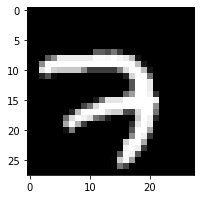

In [ ]:
plot(images[5000])

In [ ]:
labels[5000]

7

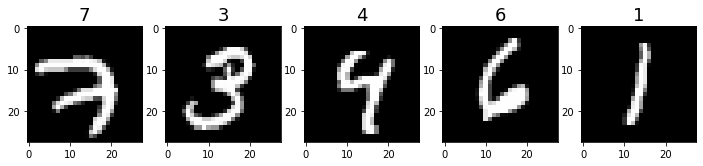

In [ ]:
plots(images[5000:5005], titles=labels[5000:5005])

## 3. Filters and convolutions

Let start with this visual explanation of [Interactive image kernels](http://setosa.io/ev/image-kernels/)

In some fields, convolution or filtering can be better understood as _correlations_. 
In practice we slide the filter matrix over the image (a bigger matrix) always selecting patches from the image with the same size as the filter. We compute the dot product between the filter and the image patch and store the scalar response which reflects the degree of similarity/correlation between the filter and image patch.

Here is a simple 3x3 filter, ie a 3x3 matrix (see [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) for more examples)

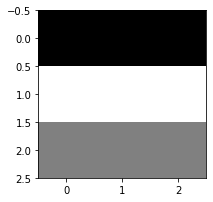

In [ ]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

plot(top)

We now create a toy image, to understand how convolutions operate.

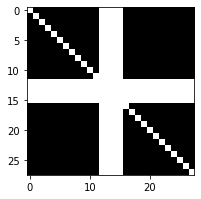

In [ ]:
cross = np.zeros((28,28))
cross += np.eye(28)
for i in range(4):
    cross[12+i,:] = np.ones(28)
    cross[:,12+i] = np.ones(28)

plot(cross)

Our `top` filter should highlight top horizontal border in the image.

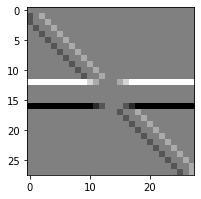

In [ ]:
from scipy.ndimage.filters import convolve, correlate

corr_cross = correlate(cross,top)

plot(corr_cross)

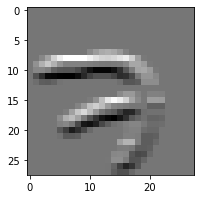

In [ ]:
corrtop = correlate(images[5000], top)
plot(corrtop)

In [ ]:
?correlate

Let's generate a few more variants of our simple 3x3 filter

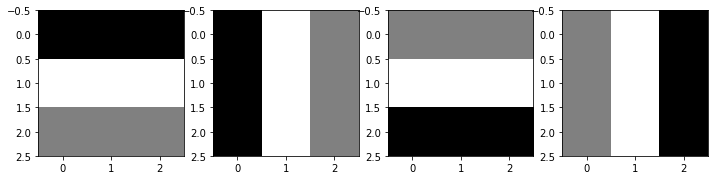

In [ ]:
straights=[np.rot90(top,i) for i in range(4)]
plots(straights)

We proceed similarly to generate a set of filters with a different behavior

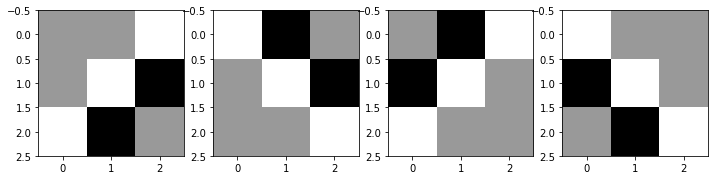

In [ ]:
br=[[ 0, 0, 1],
    [ 0, 1,-1.5],
    [ 1,-1.5, 0]]

diags = [np.rot90(br,i) for i in range(4)]
plots(diags)

We can compose filters to obtain more complex patterns

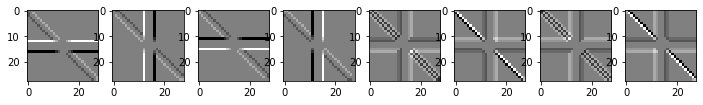

In [ ]:
rots = straights + diags
corrs_cross = [correlate(cross, rot) for rot in rots]
plots(corrs_cross)

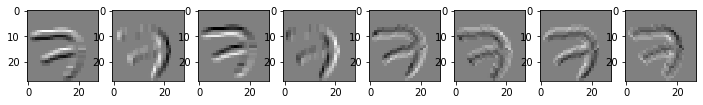

In [ ]:
rots = straights + diags
corrs = [correlate(images[5000], rot) for rot in rots]
plots(corrs)

Next we illustrate the effect of downsampling.
We select the most basic downsampling technique: __max pooling__. We keep only the maximum value for sliding windows of size ```7x7```.
__Max pooling__ is a handy technique with a few useful benefits:
- since it selects the maximum values it ensures invariance to translations
- reducing the size is helpful since data becomes more compact and easier to compare
- since max pooling reduces the size of our images, the operations performed later on in the network have bigger receptive field / concern a bigger patch in the input image and allow the discovery of higher level patterns.

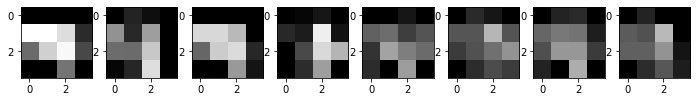

In [ ]:
import skimage

from skimage.measure import block_reduce

def pool(im): return block_reduce(im, (7,7), np.max)

plots([pool(im) for im in corrs])

We now build a classifier with convolutions.

To this end we select a set of training images depicting _eights_ and _ones_, we convolve them with our set of filters, pool them and average them for each class and filter. We will thus obtain a set of _representative_ signatures for _eights_ and for _ones_. 
Given a new test image we compute its features by convolution and pooling with the same filters and then compare them with the _representative_ features. The class with the most _similar_ features is chosen as prediction.


We keep 1000 images of _eight_ for the test set and use the remaining ones for the training: we convolve them with our bank of filters, perform max pooling on the responses and store them in ```pool8```.

In [ ]:
n=len(images)

In [ ]:
eights=[images[i] for i in range(n) if labels[i]==8]
ones=[images[i] for i in range(n) if labels[i]==1]

In [ ]:
len(eights), len(ones)

(5851, 6742)

In [ ]:
pool8 = [np.array([pool(correlate(im, rot)) for im in eights[1000:]]) for rot in rots]

In [ ]:
len(pool8), pool8[0].shape

(8, (4851, 4, 4))

For the 4 first _eights_ in our set, we plot the result of the 8 filters+pooling

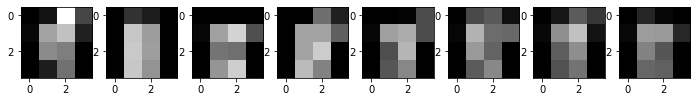

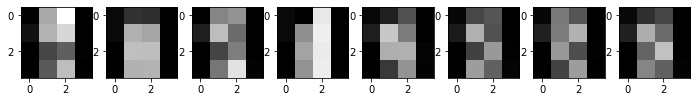

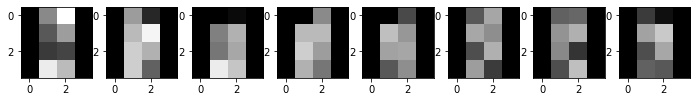

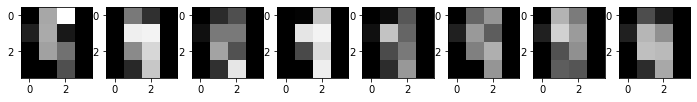

In [ ]:
plots([pool8[i][0] for i in range(8)])
plots([pool8[i][1] for i in range(8)])
plots([pool8[i][2] for i in range(8)])
plots([pool8[i][3] for i in range(8)])

Next we compute the average _eight_ by averaging all responses for each filter from _rots_.

In [ ]:
filts8 = np.array([ims.mean(axis=0) for ims in pool8])

We should obtain a set of canonical _eights_ responses for each filter.

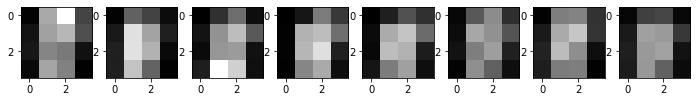

In [ ]:
plots(filts8)

We proceed similarly with training samples from the _one_ class and plot the canonical _ones_.

In [ ]:
pool1 = [np.array([pool(correlate(im, rot)) for im in ones[1000:]]) for rot in rots]
filts1 = np.array([ims.mean(axis=0) for ims in pool1])

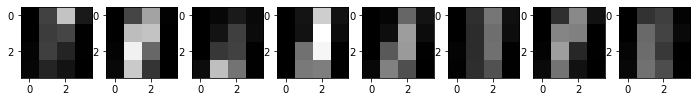

In [ ]:
plots(filts1)

Do you notice any differences between ```filts8``` and ```filts1```? Which  ones?

In the plot of 1's, the horizontal kernels are not well-defined

We define a function that correlates a given image with all filters from ```rots``` and max pools the responses.

In [ ]:
def pool_corr(im): return np.array([pool(correlate(im, rot)) for rot in rots])

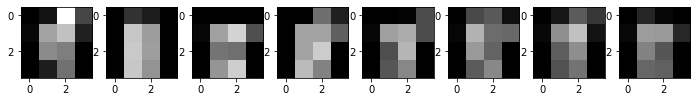

In [ ]:
plots(pool_corr(eights[1000]))

In [ ]:
# sum of squared distance
def sse(a,b): return ((a-b)**2).sum()

# function used for a voting based classifier that will indicate which one of the 
# two classes is most likely given the sse distances
# n2 comes from norm2
# is8_n2 returns 1 if it thinks it's an eight and 0 otherwise
def is8_n2(im): return 1 if sse(pool_corr(im),filts1) > sse(pool_corr(im),filts8) else 0

We perform a check to see if our function actually works. We correlate an image of _eight_ with ```filts8``` and ```filts1```. It should give smaller distance for the _eights_.

In [ ]:
sse(pool_corr(eights[0]), filts8), sse(pool_corr(eights[0]), filts1)

(25.282864, 43.071022)

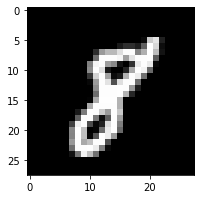

In [ ]:
plot(eights[0])

We now test our classifier on the 1000 images of _eights_ and 1000 images of _ones_

In [ ]:
nb_8_predicted_8 = np.array([is8_n2(im) for im in eights[:1000]]).sum()
nb_1_predicted_1 = np.array([(1-is8_n2(im)) for im in ones[:1000]]).sum()

acc_1 = nb_1_predicted_1/1000
acc_8 = nb_8_predicted_8/1000
acc = (acc_1 + acc_8)/2

print('accuracy :', acc)

accuracy : 0.9824999999999999


We have successfully built a classifier for _eights_ and _ones_ using features extracted with a hand-crafted bank of filters and a set of training samples. 

## 4. Practicals: improving classification with convolutional neural networks

You will now build a neural net that will learn the filters.

The first layer of the network will be a convolutional layer with $8$ filters of size $3\times 3$. Padding should be chosen such that the output feature maps have a size of $28 \times 28$. Then you will apply a Max Pooling layer to reduce the size of the image to $4\times 4$ as we did above. This will produce (once flatten) a vector of size $128 = 4\times 4\times 8$. From this vector, you need to predict if the corresponding input is a $1$ or a $8$. So you are back to a classification problem as seen in previous lessons.

You need to fill the code written below to construct your CNN. You will need to look for documentation about [torch.nn](https://pytorch.org/docs/stable/nn.html) in the Pytorch doc.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    def __init__(self):
        super(classifier, self).__init__()
        # fill the missing entries below

        # Our images have dimensions 28x28 WITH ONE SINGLE CHANNELL (if it was a RGB image, in_channels would be 3)
        # Since there are 8 kernels, the convolution should result 8 feature maps (#output channels = #kernels)
        # padding = "same" or 1

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding="same") # conv layer
        self.mp1 = nn.MaxPool2d(7) # max pooling
        self.fc = nn.Linear(in_features=128, out_features=1) # fully-connected layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        # implement your network here, do not forget to flatten your tensor after pooling
        x = self.conv1(x)
        x = self.mp1(x)
        x = torch.flatten(x, start_dim=1) # first dimension to flatten is 1
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [ ]:
conv_class = classifier()

Your code should work fine on a batch of 3 images.

In [ ]:
batch_3images = train_set.data[0:2].type(torch.FloatTensor).resize_(3, 1, 28, 28)
out = conv_class(batch_3images)
print(out.shape)
print(out)
# 3, 1, 28, 28 (input)
# 3, 8, 28, 28 (convolution)
# 3, 8, 4, 4 (pooling)
# 3, 128 (flatten 8x4x4)
# 3, 1 (prediction in linear layer)
# 3, 1 (prediction after sigmoid)

# batch size is 3, does not change

torch.Size([3, 1])
tensor([[1.0000],
        [0.9786],
        [0.0000]], grad_fn=<SigmoidBackward0>)


The following lines of code implement a data loader for the train set and the test set. No modification is needed.

[```torch.utils.data.DataLoader```](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is an iterator (an object that contains a countable number of values and that can be iterated upon) which provides the following additional features:
- Batching the data (i.e. organizing the training samples in batches);
- Shuffling the data;
- Load the data in parallel using multiprocessing workers.

In addition to the batch size and a boolean indicating if data should be shuffled, it takes as input a dataset, which is here simply a list representing our labeled data. 

For more complex processing, instead of a simple list it accepts as input an instance of [```torch.utils.data.Dataset```](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset), which is an abstract class representing a dataset, with the two following methods:
- ```__len__``` which returns the number of samples in the dataset;
- ```__getitem__``` which returns a sample from the dataset given an index.


In [ ]:
bs = 64 # batch size

l8 = np.array(0) # label for eights
eights_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                   torch.from_numpy(l8.astype(np.float32))] for e in eights] # input images of eights

l1 = np.array(1) # label for ones
ones_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), 
                 torch.from_numpy(l1.astype(np.float32))] for e in ones] # input images of ones

train_dataset = eights_dataset[1000:] + ones_dataset[1000:]
test_dataset = eights_dataset[:1000] + ones_dataset[:1000]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True)

You need now to complete the training loop in the following cell. We store the loss and accuracy (number of correct predictions / total number of samples) for each epoch. To compute the number of correct predictions, we simply threshold the output of your network and compare with the labels.

In [ ]:
def train(model, data_loader, loss_fn, optimizer, n_epochs=1):
    
    model.train(True)
    
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    
    for epoch_num in range(n_epochs):
        
        running_corrects = 0.0 # number of correct predictions
        running_loss = 0.0 # loss
        size = 0

        for data in data_loader:
            
            inputs, labels = data
            labels = labels.unsqueeze(1)
            bs = labels.size(0)

            # reset stored gradients for the parameters of the neural network
            model.zero_grad()

            # do the forward pass
            outputs = model(inputs)

            # compute the loss on the training set
            loss = loss_fn(outputs, labels)

            # do the backward pass (back propagation)
            loss.backward()

            # do a gradient descent step
            optimizer.step()   
            
            # store loss and compute num. of correct predictions
            running_loss += loss
            preds = (outputs >= 0.5).type(torch.float32)  # 1 or 0
            running_corrects += torch.sum(preds == labels)
            
            # count the number of samples
            size += bs
            
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        
        print('Epoch {} - Loss: {:.4f} Acc: {:.4f}'.format(epoch_num+1, epoch_loss, epoch_acc))
        
    return loss_train, acc_train

In [ ]:
conv_class = classifier()

# choose the appropriate loss
loss_fn = nn.BCELoss(reduction='mean')  # Binary cross-entropy loss using mean reduction

# your SGD optimizer
learning_rate = 1e-2
#optimizer_cl = torch.optim.SGD(conv_class.parameters(), lr=learning_rate)  # Stochastic Gradient descent
optimizer_cl = torch.optim.Adam(conv_class.parameters(), lr=learning_rate)  # Adam

# number of epochs
n_epochs = 40

# and train
training_loss, training_acc = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = n_epochs)

Epoch 1 - Loss: 0.0017 Acc: 0.9737
Epoch 2 - Loss: 0.0003 Acc: 0.9936
Epoch 3 - Loss: 0.0002 Acc: 0.9949
Epoch 4 - Loss: 0.0002 Acc: 0.9947
Epoch 5 - Loss: 0.0002 Acc: 0.9958
Epoch 6 - Loss: 0.0002 Acc: 0.9958
Epoch 7 - Loss: 0.0001 Acc: 0.9972
Epoch 8 - Loss: 0.0001 Acc: 0.9975
Epoch 9 - Loss: 0.0001 Acc: 0.9976
Epoch 10 - Loss: 0.0001 Acc: 0.9975
Epoch 11 - Loss: 0.0001 Acc: 0.9970
Epoch 12 - Loss: 0.0001 Acc: 0.9972
Epoch 13 - Loss: 0.0001 Acc: 0.9980
Epoch 14 - Loss: 0.0001 Acc: 0.9979
Epoch 15 - Loss: 0.0001 Acc: 0.9974
Epoch 16 - Loss: 0.0001 Acc: 0.9982
Epoch 17 - Loss: 0.0001 Acc: 0.9975
Epoch 18 - Loss: 0.0001 Acc: 0.9980
Epoch 19 - Loss: 0.0001 Acc: 0.9980
Epoch 20 - Loss: 0.0001 Acc: 0.9984
Epoch 21 - Loss: 0.0001 Acc: 0.9980
Epoch 22 - Loss: 0.0001 Acc: 0.9974
Epoch 23 - Loss: 0.0001 Acc: 0.9983
Epoch 24 - Loss: 0.0001 Acc: 0.9983
Epoch 25 - Loss: 0.0001 Acc: 0.9986
Epoch 26 - Loss: 0.0001 Acc: 0.9986
Epoch 27 - Loss: 0.0001 Acc: 0.9987
Epoch 28 - Loss: 0.0001 Acc: 0.9987
E

Text(0.5, 0, 'BCE loss')

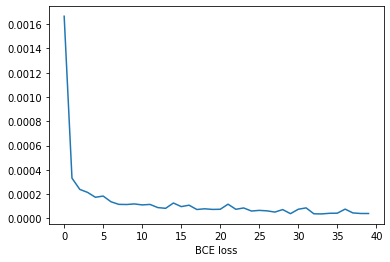

In [ ]:
plt.plot(training_loss)
plt.xlabel('epoch')
plt.xlabel('BCE loss')

Text(0.5, 0, 'accuracy')

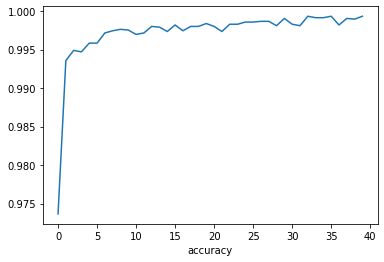

In [ ]:
plt.plot(training_acc)
plt.xlabel('epoch')
plt.xlabel('accuracy')

Our network seems to learn but we now need to check its accuracy on the test set.

In [ ]:
def test(model,data_loader):
    
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        
        inputs, labels = data
        labels = labels.unsqueeze(1)
        bs = labels.size(0)

        # reset the stored gradients for the parameters of the neural network
        model.zero_grad() 

        # do the forward pass
        outputs = model(inputs)

        # compute the loss on the training set
        loss = loss_fn(outputs, labels)    
        
        # store loss and compute num. of correct predictions
        running_loss += loss
        preds = (outputs >= 0.5).type(torch.float32)
        running_corrects += torch.sum(preds == labels)

        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [ ]:
test(conv_class,test_loader)

Test - Loss: 0.0006 Acc: 0.9905


You should have slightly improved the performance compared with the handcrafted set of filters.

Now, try to change the optimizer to Adam, retrain, and see how it performs.

In [ ]:
# It performs better

How many parameters did your network learn?

In [ ]:
(3*3 + 1)*8 + 128 + 1  # +1 e +1 são bias do kernel e da rede neural

209

You can see them as follows:

In [ ]:
num_param = 0
for p in conv_class.parameters():
    print(p.data)
    num_param += p.detach().numpy().size
    
print(num_param)

tensor([[[[-0.8185, -1.1968,  0.6115],
          [-1.2678, -1.8920,  0.0968],
          [ 0.3756,  1.3973,  1.3107]]],


        [[[ 1.2334, -1.4689, -1.5881],
          [ 1.6174, -0.1933, -0.1067],
          [ 0.0617,  0.6765,  2.0856]]],


        [[[ 0.8917,  0.7042,  0.3413],
          [-0.3082,  0.8913, -1.2753],
          [ 0.5205,  1.8993, -2.2456]]],


        [[[-0.5196, -0.1452,  0.0996],
          [-1.1470,  0.2255,  0.7618],
          [ 1.1171,  0.2194,  0.0999]]],


        [[[-0.7273,  0.8449,  1.4082],
          [ 0.7312,  0.3547, -0.6476],
          [ 0.5231, -0.7629, -1.2679]]],


        [[[ 1.1794,  0.6379, -0.6276],
          [ 0.6547,  0.0188, -0.9358],
          [ 1.0214, -0.2642, -1.2273]]],


        [[[-2.8158, -3.1897, -5.3422],
          [-5.6890, -2.5433, -0.9527],
          [ 1.3977, -4.0325, -4.6786]]],


        [[[ 0.2805,  1.2864,  1.1184],
          [ 0.8247, -0.7959,  1.3047],
          [-0.4286, -1.9951,  0.2086]]]])
tensor([-0.8692, -1.0586,  0.3668

In [ ]:
for p in conv_class.parameters():
    T_w = p.data.numpy()
    break

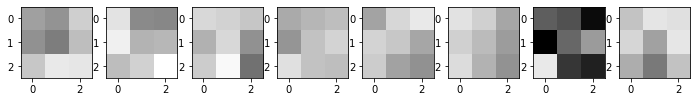

In [ ]:
plots([T_w[i][0] for i in range(8)])